# Direct S3 Access GEDI L4A from the NASA Earthdata Cloud in R

GEDI L4A Datasets are available through NASA's Earthdata Cloud. NASA Earthdata on Cloud is always free and accessible via HTTPS or direct [S3](https://aws.amazon.com/s3/) bucket access. With direct S3 access, you can bring your "code to the data", making your processing faster and more scalable. Direct S3 access to NASA Earthdata on Cloud is only available if your Amazon Web Services ([AWS](https://aws.amazon.com/)) instance is set up in the `us-west-2` region. If you are new to the Earthdata Cloud, these NASA Earthdata [primers](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials/cloud-primer-amazon-web-services) and [tutorials](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials/how-cloud-earth-scientists) are good resources to get you started. 

To run R on a Jupyter Notebook:
1. Install `IRKernel` packages by running the following in your R console:: `install.packages("IRkernel")`
3. Install kernel spec in your R by running `IRkernel::installspec()`.
4. Now, the R kernel will be available along with the Python Kernel in the top-right corner of the Jupyter Notebook.

To access a Juypter Notebook on [AWS EC2](https://aws.amazon.com/ec2/) instance:
1. On the AWS EC2 instance, start Juypter Notebook on port 8888 with the 'no-browser' parameter: `jupyter notebook --no-browser --port=8888`
1. On your local machine, forward port 8000 to the remote port 8888 : `ssh -i my-key-pair.pem -L 8000:localhost:8888 my-instance-user-name@my-instance-IPv6-address`
1. Now, the Jupyter Notebook can be accessed at `http://localhost:8000` in your local browser.

**Important**: [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/) is required to obtain the S3 temporary credentials and direct access S3 objects bucket. First, set up NASA Earthdata Login authentication using a `.netrc` file. Please refer to the instructions here: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

In this tutorial, we will retrieve the GEDI L4A dataset from the Earthdata Cloud using direct S3 access.

Let's first import some R packages. We will use [geojsonR](https://mlampros.github.io/geojsonR/) to read GeoJSON files, [aws.s3](https://cloud.r-project.org/web/packages/aws.s3/index.html) to for AWS S3 access, and [hdf5r](https://cran.r-project.org/web/packages/hdf5r/index.html) for directly accessing GEDI L4A HDF files from the AWS S3.

In [1]:
library(geojsonR)
library(aws.s3)
library(stringr)
library(httr)
library(jsonlite)
library(hdf5r)

We will read an area within the [Sequoia National Park](https://www.nps.gov/seki/index.htm) as a GeoJSON file. The Sequoia National Park in the Sierra Nevada, California, is known for its giant sequoia trees.

If an area of interest is already defined as a polygon, the polygon file (geojson, shapefile, or kml) can be used to find overlapping GEDI L4A files. More details about this capability are described on [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

We will query the CMR API to find spatially overlapping GEDI L4A granules.

In [2]:
poly_f <- "polygons/sequioa_np.geojson"
poly <- FROM_GeoJson(url_file_string = poly_f)
# CMR API base url
cmrurl <- "https://cmr.earthdata.nasa.gov/search/" 
doi <- "10.3334/ORNLDAAC/2056" # GEDI L4A DOI 
# doi search to get concept_id
doisearch <- str_c(cmrurl, "collections.json?doi=", doi)
r <- GET(doisearch) 
warn_for_status(r)
concept_id <- content(r)$feed$entry[[1]]$id

page_num <- 1
page_size <- 2000 # CMR page size limit
granulesearch <- str_c(cmrurl, "granules.json")
s3_arr <- c()

while (TRUE) {
    body <- list('collection_concept_id' = concept_id, 
             'page_size' = page_size, 
             'page_num' = page_num, 
             'shapefile' = upload_file(poly_f, type="application/geo+json"),
             'simplify-shapefile' = "true")
    r <- POST(granulesearch, body = body)
    warn_for_status(r)
    granules <- content(r)$feed$entry
    if (length(granules)){
        for (g in granules) {
            for (link in g$links){
                if (startsWith(link$href, "s3://")) {
                    s3_arr <- c(s3_arr, link$href)
                }
            }
        }
        page_num <- page_num + 1
    } else {
        break
    }
}
sprintf("Total GEDI L4A granules found: %s", length(s3_arr))

[1] "Total GEDI L4A granules found: 79"

The `s3_arr` contains a list of `s3` granule links, starting with `s3://`. Let's print the first two items of the `s3_arr`.

In [3]:
print(s3_arr[1:2])

[1] "s3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019128143946_O02279_03_T04719_02_002_02_V002.h5"
[2] "s3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019135115649_O02386_03_T01720_02_002_02_V002.h5"


Now, let's read the first file in the above list. A temporary S3 Credentials is needed for read-only, same-region, direct access to S3 objects on the Earthdata cloud. Each of the DAACs has its own endpoint. More information about S3 credentials for ORNL DAAC is available at: https://data.ornldaac.earthdata.nasa.gov/s3credentialsREADME. 

We will now retrieve the credentials for ORNL DAAC for GEDI L4A access. These credentials are temporary and currently valid for one hour. You will first need to set up the `.netrc` and `.urs_cookies` files as described [here](https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget).

In [4]:
# provide the full paths to the netrc and urs_cookies files
netrc_path <- ".netrc" 
cookie_path <- ".urs_cookies"
# configuring CURL options
set_config(config(followlocation=1, netrc=1, netrc_file=netrc_path,
                  cookie=cookie_path, cookiefile=cookie_path, cookiejar=cookie_path))
# retrieving ORNL DAAC S3 credentials
r <- GET("https://data.ornldaac.earthdata.nasa.gov/s3credentials", accept_json()) 
warn_for_status(r)
s3credentials <- fromJSON(content(r, as = 'text', encoding = 'utf-8'))
# printing expiration time
sprintf("The S3 credentials will expire on %s UTC", s3credentials$expiration)

[1] "The S3 credentials will expire on 2022-10-05 19:24:37+00:00 UTC"

We will use [aws.s3](https://cloud.r-project.org/web/packages/aws.s3/index.html) for AWS S3 access. We will first set the environment with the S3 credentials.

In [5]:
Sys.setenv("AWS_ACCESS_KEY_ID" = s3credentials$accessKeyId,
           "AWS_SECRET_ACCESS_KEY" = s3credentials$secretAccessKey,
           "AWS_DEFAULT_REGION" = "us-west-2",
           "AWS_SESSION_TOKEN" = s3credentials$sessionToken)

Let's read the first file and print the first-level variable names.

In [6]:
l4a_f <- s3_arr[1]
hf <- s3read_using(FUN = H5File$new, object = l4a_f)
# printing the first level header
hf$ls(recursive=FALSE)$name

[1] "ANCILLARY" "BEAM0000"  "BEAM0001"  "BEAM0010"  "BEAM0011"  "BEAM0101" 
 [7] "BEAM0110"  "BEAM1000"  "BEAM1011"  "METADATA"

We will now read the latitude and the AGBD variables of one of the beam (`BEAM0110`) and plot agbd against latitude.

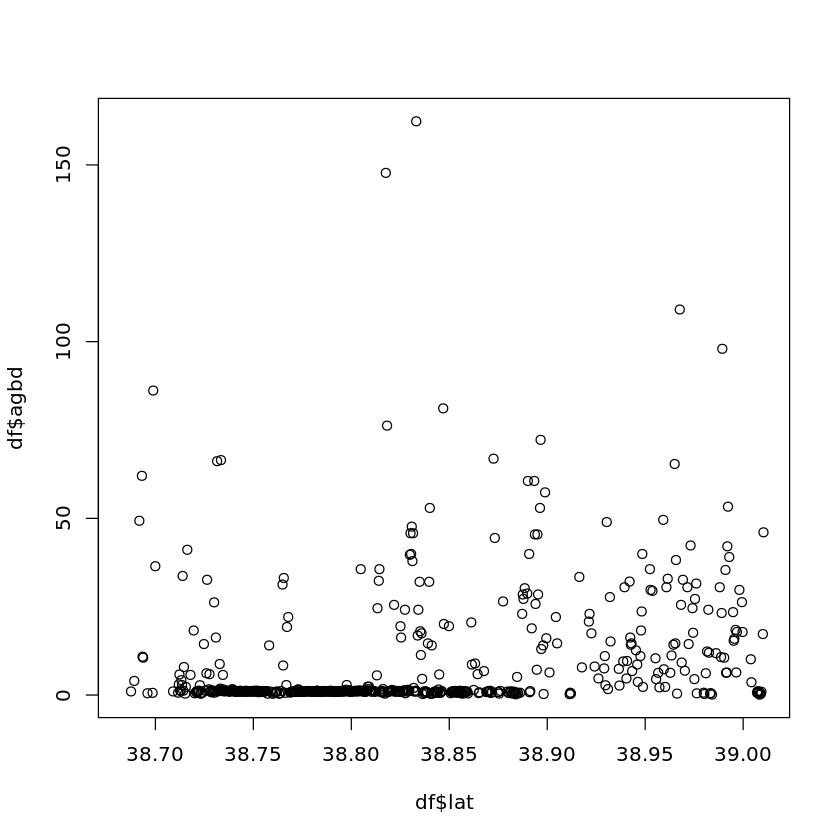

In [7]:
lat <- hf[['BEAM0110']][['lat_lowestmode']][50000:51000]
agbd <- hf[['BEAM0110']][['agbd']][50000:51000]
df <- do.call(rbind, Map(data.frame, lat_lowestmode=lat, agbd=agbd))
# assigning no data values
df$agbd[df$agbd == -9999] <- NA
# plot
plot(x=df$lat, y=df$agbd)

Now let's close the HDF file

In [8]:
hf$close_all()